In [2]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
DEBUG = False

In [4]:
#!/usr/bin/env python

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import spectrum
from astropy.io import ascii
from astropy.io import fits
from scipy import interpolate
import numpy
from matplotlib import pyplot as plot
import skimage.morphology
from scipy.optimize import least_squares
from astropy.stats import biweight_location
import numpy as np
from astropy.table import Table, Column

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import os
import pickle

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter

from astropy.io import ascii
from collections import OrderedDict
import os
from astropy.io import ascii

from scipy.interpolate import interp1d
params = {'legend.fontsize': 'x-small',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}
plt.rcParams.update(params)

import matplotlib.pyplot as plt

from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import glob
from astropy.io import fits
from astropy import wcs
import sys, traceback
import argparse

KeyboardInterrupt: 

In [ ]:
# simple continuum removal though spline interpolation
def confitSpl(wls, s, n = 10, kappaL=2.5, kappaU=2.5, output_fit=False, smooth=0., mask=None, PLOT=False, maxiter=15):
    if mask == None:
        mask_ = wls > -1 # use all
    else:
        mask_ = mask.copy()
    mask_ *= ~ np.isnan(s)
    l = len(wls)
    l = np.floor(l/n)
    dwl = (wls[-1]-wls[0])/n

    niter = 0
    nmasked = len(mask_[~mask_])
    while niter < maxiter:
        bwls = []
        bs   = []

        # put one point at the blue end, window only half the normal binsize
        wlstart = wls[0]
        wlstop  = wls[0] + dwl/2.
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_

        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )
        # normal points, normal binsize
        for i in range(n-1):
                wlstart = wls[0]  + dwl/2. + dwl * i
                wlstop  = wls[0]  + dwl/2. + dwl * (i + 1)
                ii = (wls >= wlstart) * (wls <= wlstop)
                if type(mask_) != type(None): ii *= mask_
                binned_wls = np.mean( wls[ii] )
                bwls.append( binned_wls )
                bs.append(    np.median(   s[ii] ) )
        # put one point at the red end, window only half the normal binsize
        wlstart = wls[-1] - dwl/2.
        wlstop  = wls[-1]
        ii = (wls >= wlstart) * (wls <= wlstop)
        if type(mask_) != type(None): ii *= mask_
        binned_wls = np.mean( wls[ii] )
        bwls.append( binned_wls )
        bs.append(    np.median(   s[ii] ) )

        tck = interpolate.splrep(bwls,bs,s=smooth)
        c = interpolate.splev(wls,tck,der=0)

        res = s-c
        sigma = np.std(res[mask_])

        inliers  = ( res) <= kappaU*sigma
        inliers *= (-res) <= kappaL*sigma

        mask_ *= inliers
        nmasked_new = len(mask_[~mask_])
        if nmasked_new == nmasked:
            break
        nmasked = nmasked_new

        niter += 1
    if PLOT:
        f=plt.figure()
        plt.plot(wls,s)
        plt.plot(wls,c)
        plt.plot(wls[~mask_],s[~mask_],'r.')
        plt.ylim([-1.,1.])

    # filter lowest and highest 3 fourier channels
    sc = s-c

    if output_fit:
        return sc,c
    else:
        return sc
    
    

def line_detect(ww, csout, threshold):
    # line detection (everything above cetain threshold)
    jj = csout > threshold

    # labelling line detections
    label = skimage.morphology.label(jj)
    ll = np.unique( label )

    lineset = []
    dlineset = []

    for l in ll:
        if l == 0:
            continue
        ii = l == label
        f = np.sum( csout[ii] )
        wl_com = np.sum( ww[ii]*csout[ii] ) /np.sum(csout[ii] )
        #print("{} {:.2f}A {:.2f}".format(l, wl_com, f))
        lineset.append(wl_com)
        dlineset.append(2.)
    return lineset, dlineset, jj

def masked_biweight(cube_slice, mask):
    return biweight_location( cube_slice[mask] )



def masked_sum(cube_slice, mask):
    return np.sum( cube_slice[mask] )


def masked_biweightwsum(cube_slice, mask):
    return biweight_location( cube_slice[mask] ) * np.sum(mask)



def extract(r, s, outmap, method):
    mask = np.sum( outmap == r['id'], axis=0) > 0

    sout = np.zeros( s.data.shape[0]  )
    N = np.sum(mask)
    for i in range(s.data.shape[0]):
        #sout[i] = np.sum( s.data[i][mask] )
        #sout[i] = biweight_location( s.data[i][mask] )*N # statistically stable mean times number of pixel
        sout[i] = method( s.data[i], mask )

    ww = s.grid()
    return ww,sout, mask



def nextract(r, s, outmap, MAX_SAMPLES = 30):
    """
    Shifts the aperture corresponding to a detection around in the noise cube to
    sample the noise N times. The mask is shifted such as to not overlap
    wiht he previous location of the mask

    Original, actual mask
    xxxxxxxxxx
    xxx..xxxxx
    xx...xxxxx
    xxx..xxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 1
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 2
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    x..xxxxxxx
    ...xxxxxxx
    x..xxxxxxx

    Sample 3
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 4
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxx..xxxx
    xxx...xxxx
    xxxx..xxxx

    Sample 5
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx

    Sample 6
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxxxxx
    xxxxxxx..x
    xxxxxx...x
    xxxxxxx..x
    """

    mask = np.sum( outmap == r['id'], axis=0) > 0

    # determine masked, region size
    xx = np.arange(mask.shape[1])
    yy = np.arange(mask.shape[0])

    X,Y = np.meshgrid(xx,yy)
    minx,maxx = X[mask].min(), X[mask].max()
    miny,maxy = Y[mask].min(), Y[mask].max()
    sx = maxx - minx + 2
    sy = maxy - miny + 2
    nx,ny = mask.shape[1]//sx, mask.shape[0]//sy

    #f = plt.figure(figsize = [7,7])
    #plt.imshow(mask)

    all_sout = []
    count = 1
    print("Sampling noise in {} separate regions".format( min(nx * ny, MAX_SAMPLES)  ) )
    for i in range(nx):
        if count > MAX_SAMPLES:
            break
        
        for j in range(ny):
            print("Sampling noise column {} and row {}".format(i, j))
            _mask = mask < 0 # empty mask
            #print(sy*(j), sy*(j+1),sx*(i), sx*(i+1), miny, miny+sy, minx, minx+sx )

            m = mask[miny:miny+sy, minx:minx+sx]
            _mask[sy*(j):sy*(j)+m.shape[0],sx*(i):sx*(i)+m.shape[1]] = m
            #f = plt.figure(figsize = [7,7])
            #plt.imshow(_mask)

            sout = np.zeros( s.data.shape[0]  )
            for k in range(s.data.shape[0]):
                sout[k] = biweight_location( s.data[k][_mask] )
            all_sout.append(sout)
            count += 1

    ww = s.grid()
    return ww, np.array(all_sout), mask


if DEBUG:
    IFU = '023'
    field = 'gama09E'
    id = 195
    foutmap = "../data/map{}_{}.fits.gz".format(field,IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field,IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field,IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    flinelist = "linelist.txt"

    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    ns = spectrum.readSpectrum(fnoisecube)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]

    ww,sout, mask = extract(r, s, outmap)
    ww,nsout, mask = nextract(r, ns, outmap)

    mm = np.std(nsout,axis=0)
    plt.plot(ww,sout)
    plt.fill_between(ww, 5.*mm, -5.*mm,alpha=0.3, edgecolor='black', facecolor='grey', label="5 - sigma")
    plt.fill_between(ww, mm, -mm,alpha=0.3, edgecolor='black', facecolor='grey', label="1 - sigma")
    plt.legend()
    plt.xlabel("wavelength [A]")
    plt.ylabel("flux")

In [ ]:
   
from scipy.optimize import least_squares

import numpy as np


def plot_spec(ax1, ax2, ww, csout, nsout, wldetect, jj, results, r, s, bad = [[5275.,5325.]]):
    global layoutmode
    #f = plt.figure(figsize = [15,10])
    #ax1 = plt.axes()
    ax1.axvline(wldetect, c='r')

    ax1.plot(ww, csout, drawstyle='steps-mid')
    mm = np.std(nsout,axis=0)
    ax1.fill_between(ww, 5.*mm, -5.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, 2.*mm, -2.*mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.fill_between(ww, mm, -mm,alpha=0.2, edgecolor='black', facecolor='grey')
    ax1.set_xlabel("wl[A]")

    ii_bad = ww < 0.
    for b in bad:
        ax1.axvspan(b[0], b[1], alpha=0.5, color='grey')
        ii_bad += (ww > b[0]) * (ww < b[1])

    ax1.plot(ww[~ii_bad * jj], csout[~ii_bad * jj], 'r.')
    ax1.axes.get_yaxis().set_visible(False)

    pad = 30
    minz, maxz = 0,s.data.shape[0]
    z1,z2 = max(r["zmin"]-pad,minz),min(r["zmax"]+pad,maxz)


    # zoom in on detection line
    ax2.plot(ww[z1:z2], csout[z1:z2], drawstyle='steps-mid')
    
    if not layoutmode:
        ax2.fill_between(ww[z1:z2], 5.*mm[z1:z2], -5.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], 2.*mm[z1:z2], -2.*mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')
        ax2.fill_between(ww[z1:z2], mm[z1:z2], -mm[z1:z2],alpha=0.2, edgecolor='black', facecolor='grey')


    #ax2.set_ylim([-.05,.1])
    ax2.set_xlabel("wl[A]")
    ax2.set_ylabel("mean flux \n[$10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$ $arcsec^{-2}$]")
    ylim = ax2.get_ylim()
    ax1.tick_params(size=5)


    ax1.set_ylabel("")

    if len(results) > 0:
        ii = (results[:,1] > ww[0]) * (results[:,1] < ww[-1])
        results = results[ii]
        for r in results:
            #s = "line {:.1f}A {:.1f}s\n{:.4e}erg/s/cm^2".format(r[1],r[2], r[0]*cal_interp(r[1]) )
            s = "{:.1f}A ".format(r[1],r[2] )
            #print(s)
            draw_line(ax1, r[1], s)
            
    ax1.set_xlim([3510.,5500.])

if True:
    layoutmode = False
    
    field = "gama09Gfin"
    IFU = "013"
    id = 2
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)

    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    t = ascii.read(fcatalog, format="ecsv")
    ii = t['id'] == id
    r = t[ii][0]
    
    
    # test
    foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
    fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
    frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
    fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)
    fcatalog = "../data/sf{}_{}.cat".format(field,IFU)
    flinelist = "linelist.txt"

    # set calibration
    s = spectrum.readSpectrum(fincube)
    c = s.data
    wlgrid = s.grid()
    print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
    cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )

    threshold = 0.15

    wlwin = 30.
    
    print("Loading data ...")
    outmap = fits.getdata(foutmap)
    s = spectrum.readSpectrum(fincube)
    sraw = spectrum.readSpectrum(frawincube)
    ns = spectrum.readSpectrum(fnoisecube)

    wldetect = r["wl_com"]

    id, ra,dec = r["id"], r["ra_com"], r["dec_com"]
    print("Creating plot for source {}".format(id))

    print("Extracting spactra ...")
    ww, sout, mask    = extract(r, s, outmap, method = masked_biweightwsum)
    ww, sout_unsmoothed, __  = extract(r, sraw, outmap, method = masked_biweightwsum)

    mm = np.std(nsout,axis=0)
    
    print("WARNING ERRORS ARE WRONG")
    ww, nsout, mask = nextract(r, ns, outmap, MAX_SAMPLES = 2)

    # continuum removal
    csout            = confitSpl(ww, sout, PLOT=False)
    csout_unsmoothed = confitSpl(ww, sout_unsmoothed, PLOT=False)

    f = plt.figure(figsize=[15,5])
    ax2 = plt.subplot(121)
    ax1 = plt.subplot(122, sharey=ax2)

    pixelscale = np.abs( s.hdu.header["CDELT1"]*3600. )
    A = pixelscale**2. # pixelsize
    
    yy = sout*cal_interp(ww)*1e17/A
    
    plot_spec(ax1, ax2, ww, sout*cal_interp(ww)*1e17/A, nsout*cal_interp(ww)*1e17/A, wldetect, jj, results, r, s, bad = [[5275.,5325.]])

    ax2.set_ylim([ min( np.nanmin(yy),np.min(-mm) )   ,np.nanmax(yy)])
    
    if True:
        #ax7B = ax1.twinx()
        ax7B = ax1
        ax7B.plot(ww, sout_unsmoothed*cal_interp(ww)*1e17/A, alpha=0.2)
        ax7B.set_ylabel("$\Sigma$ \n[$10^{17}$ $erg$ $s^{-1}$ $cm^{-2}$ $A^{-1}$]")
        #ax7B.set_ylim([-30.,70.])
        __,ypos = ax7B.get_ylim()


In [ ]:
min( np.nanmin(yy),np.min(mm) )

In [ ]:
mm = np.std(nsout,axis=0)

#plt.plot(ww,sout_unsmoothed)
plt.plot(ww,mm)
#plt.plot(ww,sout)
plt.errorbar(ww,sout, mm)

In [46]:
from astropy.table import Table, Column
from astropy.io.fits import PrimaryHDU, BinTableHDU, ImageHDU


#table         1 BinTableHDU     27   464105R x 9C  
t = Table()
for dt in ['D', 'D', '16A', 'D', 'D', 'D', 'D', 'D', 'D']:
    t.add_column(Column(dtype='d'))
    
t.add_row()
#t.add_row()
#t.add_row()



hdu1 = PrimaryHDU()
hdu2 = BinTableHDU(t)

hdu3 = ImageHDU()
hdu4 = ImageHDU()
hdu5 = ImageHDU()

mm = np.std(nsout,axis=0)

hdu3.data = [sout]
hdu4.data = [mm]
hdu5.data = np.array( [~np.isnan(mm)], dtype=int)

new_hdul = fits.HDUList([hdu1, hdu2, hdu3, hdu4, hdu5])
new_hdul.writeto('../test_max.fits', overwrite=True)

In [36]:
hdu5.data.shape

(2, 1036)

<ErrorbarContainer object of 3 artists>

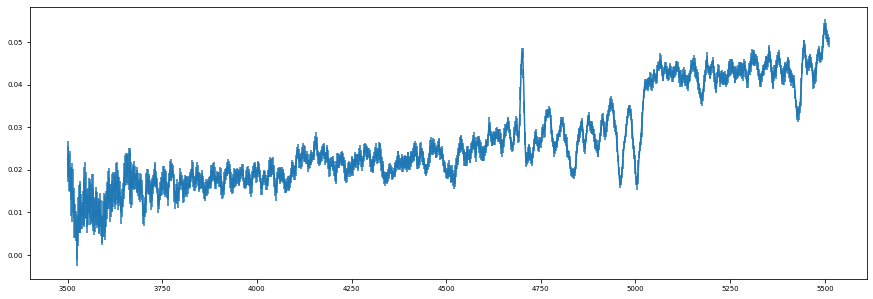

In [31]:
plt.errorbar(ww, sout, mm)

# for later work to loop over all

In [99]:
t = Table.read("../data/filtaugm_gama09EF.cat", format="ascii.ecsv")
t = Table.read("../data/augm_gama09EFGHfin.cat", format="ascii.ecsv")

catalogs = {}

# catI
jj  = t["dx"] < 2.
jj *= t["dy"] < 2.
jj *= t["dz"] < 2.
jj *= t["flux"] > 2e-17
jj *= ~t["touches_nan"] 
jj *= ~t["touches_edge"] 
jj *= (t["field"] == "gama09Gfin")
catalogs["catI"] = t[jj]

#catII
jj  = t["dx"] < 2.5
jj *= t["dy"] < 2.5
jj *= t["dz"] < 2.5
jj *= ~((t["dx"] < 2.) * (t["dy"] < 2.) * (t["dz"] < 2.))
jj *= t["flux"] > 2e-17
jj *= ~t["touches_nan"]
jj *= ~t["touches_edge"]
catalogs["catII"] = t[jj]


#catIII
jj  = t["dx"] < 2.5
jj *= t["dy"] < 2.5
jj *= t["dz"] < 2.5
jj *= t["flux"] <= 2e-17
jj *= t["flux"] > 1e-17
jj *= ~t["touches_nan"]
jj *= ~t["touches_edge"]
catalogs["catIII"] = t[jj]

#interesting
jj  = (t["field"]  == "gama09E") * (t["ifu"]  == "024") * (t["id"]  == 116)
catalogs["interesting"] = t[jj]



cat = "catI"

#jj *= t["ifu"] == '023'
#jj *= t["ifu"] == '023'

print("{} objects fall into cut criteria of category {}.".format( len(catalogs[cat]), cat))

214 objects fall into cut criteria of category catI.


In [ ]:
for index,r in enumerate(catalogs[cat]):
    IFU = r["ifu"]
    field = r["field"]
    id = r["id"]
    print("Generating plot for field {} ifu {} id {}...".format(field, IFU, id))
    try:
    #if True:
        fincube = "../data/sf{}_{}.fits.gz".format(field, IFU)
        fcatalog = "../data/augm_gama09EF.cat".format(field,IFU)
        foutmap = "../data/map{}_{}.fits.gz".format(field, IFU)
        frawincube = "../data/{}_{}.fits.gz".format(field, IFU)
        fnoisecube = "../data/sfnc{}_{}.fits.gz".format(field, IFU)

        SKIPERRSPEC = False
        layoutmode = False
        
        
        figname = "../catalog_plots/{cat}/{field}/{field}_{ifu}_{id:04d}.pdf".format(cat=cat,field=field,ifu=IFU,id=int(id))
        if os.path.exists(figname):
            print("Figure {} already exists. Skipping.".format(figname))
            continue
    

        image_catalog = get_image_catalog()

        # load flux calibration
        flinelist = "linelist.txt"

        threshold = 0.1 # line detection threshold
        wlwin = 50. # width of window for peak fit
        width = 25./3600. # size for slice plots and aux images

        # load data
        outmap = fits.getdata(foutmap)
        s = spectrum.readSpectrum(fincube)
        sraw = spectrum.readSpectrum(frawincube)
        ns = spectrum.readSpectrum(fnoisecube)


        # set calibration
        wlgrid = s.grid()
        print("Using constant count to flux conversion of {} erg/s/cm^2/A/cnt".format(1e-17))
        cal_interp = interpolate.interp1d(wlgrid, [1e-17]*len(wlgrid) )



        mk_detection_plot(figname, field, IFU, id, r, s, sraw, ns, outmap, image_catalog, 
                       threshold, wlwin, width, cal_interp, layoutmode=layoutmode, SKIPERRSPEC=SKIPERRSPEC, filename_appendix="")
    except Exception as e:
        if index == 0:
            # If an exception alrady occurs in the first plot, do not catch it
            # fir instance in case we forgot to create the target directories for the plots.
            raise e
        print("Error generating plot for field {} ifu {} id {}".format(field, IFU, id))

Generating plot for field gama09Gfin ifu 013 id 2...
Found image catalog pickle ../gbimages/catalog.pickle ...
Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_013_0002.pdf.
Generating plot for field gama09Gfin ifu 013 id 6...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_013_0006.pdf.
Generating plot for field gama09Gfin ifu 013 id 41...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_023_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_023_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_013_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_013_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_013_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_023_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_023_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_013_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_013_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_013_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_013_0041.pdf.
Generating plot for field gama09Gfin ifu 013 id 105...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_023_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_023_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_013_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_013_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_013_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_023_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_023_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_013_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_013_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_013_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_013_0105.pdf.
Generating plot for field gama09Gfin ifu 014 id 241...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_014_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_014_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_014_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_014_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_014_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_014_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_014_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_014_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_014_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_014_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_014_0241.pdf.
Generating plot for field gama09Gfin ifu 015 id 15...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0015.pdf.
Generating plot for field gama09Gfin ifu 015 id 88...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0088.pdf.
Generating plot for field gama09Gfin ifu 015 id 93...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0093.pdf.
Generating plot for field gama09Gfin ifu 015 id 222...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_034_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_034_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_034_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_034_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_034_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_034_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_034_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_034_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_034_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_034_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0222.pdf.
Generating plot for field gama09Gfin ifu 015 id 230...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_024_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_024_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_024_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_024_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_024_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_024_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_024_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_024_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_024_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_024_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0230.pdf.
Generating plot for field gama09Gfin ifu 015 id 252...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_015_0252.pdf.
Generating plot for field gama09Gfin ifu 016 id 18...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_027_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_027_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_027_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_027_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_027_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_027_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_027_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_027_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_027_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_027_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_016_0018.pdf.
Generating plot for field gama09Gfin ifu 016 id 90...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_027_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_027_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_027_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_027_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_027_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_027_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_027_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_027_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_027_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_027_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_016_0090.pdf.
Generating plot for field gama09Gfin ifu 016 id 92...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_027_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_027_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_027_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_027_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_027_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_027_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_027_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_027_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_027_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_027_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_016_0092.pdf.
Generating plot for field gama09Gfin ifu 021 id 63...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_031_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_031_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_031_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_031_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_031_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_031_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_031_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_031_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_031_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_031_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_021_0063.pdf.
Generating plot for field gama09Gfin ifu 023 id 56...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_023_0056.pdf.
Generating plot for field gama09Gfin ifu 023 id 235...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_023_0235.pdf.
Generating plot for field gama09Gfin ifu 024 id 3...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0003.pdf.
Generating plot for field gama09Gfin ifu 024 id 5...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0005.pdf.
Generating plot for field gama09Gfin ifu 024 id 10...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0010.pdf.
Generating plot for field gama09Gfin ifu 024 id 67...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0067.pdf.
Generating plot for field gama09Gfin ifu 024 id 102...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0102.pdf.
Generating plot for field gama09Gfin ifu 024 id 186...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_024_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_024_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_024_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_024_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_024_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_024_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_024_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_024_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_024_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_024_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0186.pdf.
Generating plot for field gama09Gfin ifu 024 id 205...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_015_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_015_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_015_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_015_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_015_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_015_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_015_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_015_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_015_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_015_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0205.pdf.
Generating plot for field gama09Gfin ifu 024 id 216...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_034_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_034_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_034_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_034_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_034_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_034_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_034_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_034_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_034_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_034_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_024_0216.pdf.
Generating plot for field gama09Gfin ifu 025 id 6...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_025_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_025_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_025_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_025_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_025_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_025_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_025_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_025_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_025_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_025_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_025_0006.pdf.
Generating plot for field gama09Gfin ifu 025 id 8...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_035_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_035_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_035_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_035_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_035_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_035_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_035_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_035_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_035_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_035_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_025_0008.pdf.
Generating plot for field gama09Gfin ifu 025 id 101...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_026_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_026_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_026_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_026_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_026_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_026_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_026_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_026_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_026_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_026_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_025_0101.pdf.
Generating plot for field gama09Gfin ifu 026 id 96...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

/home/idies/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/idies/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error generating plot for field gama09Gfin ifu 026 id 96
Generating plot for field gama09Gfin ifu 027 id 28...
Found image catalog pickle ../gbimages/catalog.pickle ...
Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sa

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_037_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_037_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_037_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_037_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_037_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_037_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_037_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_037_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_037_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_037_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_027_0046.pdf.
Generating plot for field gama09Gfin ifu 028 id 23...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09F_028_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09F_028_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09F_028_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09F_028_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09F_028_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09F_028_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09F_028_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09F_028_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09F_028_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09F_028_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_028_0023.pdf.
Generating plot for field gama09Gfin ifu 028 id 92...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_028_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_028_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_028_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_028_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_028_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_028_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_028_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_028_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_028_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_028_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_028_0092.pdf.
Generating plot for field gama09Gfin ifu 030 id 29...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/114-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/115-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/116-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/117-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 030 id 29
Generating plot for field gama09Gfin ifu 031 id 61...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_031_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_031_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_031_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_031_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_031_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_031_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_031_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_031_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_031_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_031_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_031_0061.pdf.
Generating plot for field gama09Gfin ifu 031 id 264...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_031_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_031_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_031_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_031_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_031_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_031_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_031_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_031_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_031_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_031_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_031_0264.pdf.
Generating plot for field gama09Gfin ifu 032 id 115...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_032_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_032_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_032_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_032_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_032_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_032_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_032_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_032_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_032_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_032_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_032_0115.pdf.
Generating plot for field gama09Gfin ifu 032 id 117...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_032_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_032_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_032_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_032_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_032_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_032_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_032_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_032_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_032_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_032_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_032_0117.pdf.
Generating plot for field gama09Gfin ifu 032 id 195...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_032_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_032_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_032_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_032_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_032_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_032_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_032_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_032_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_032_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_032_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_032_0195.pdf.
Generating plot for field gama09Gfin ifu 033 id 30...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_034_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_034_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_034_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_034_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_034_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_034_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_034_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_034_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_034_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_034_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_033_0030.pdf.
Generating plot for field gama09Gfin ifu 033 id 119...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_033_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_033_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_033_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_033_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_033_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_033_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_033_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_033_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_033_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_033_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_033_0119.pdf.
Generating plot for field gama09Gfin ifu 033 id 133...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_034_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_034_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_034_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_034_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_034_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_034_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_034_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_034_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_034_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_034_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_033_0133.pdf.
Generating plot for field gama09Gfin ifu 033 id 145...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_043_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_043_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_043_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_043_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_043_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_043_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_043_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_043_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_043_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_043_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_033_0145.pdf.
Generating plot for field gama09Gfin ifu 034 id 21...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Sampling noise column 4 and row 19
Addim image ../gbimages/hsc/gama09E_044_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_044_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_044_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_044_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_044_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_044_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_044_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_044_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_044_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_044_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_034_0021.pdf.
Generating plot for field gama09Gfin ifu 035 id 107...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_035_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_035_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_035_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_035_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_035_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_035_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_035_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_035_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_035_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_035_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_035_0107.pdf.
Generating plot for field gama09Gfin ifu 035 id 111...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_036_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_036_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_036_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_036_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_036_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_036_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_036_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_036_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_036_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_036_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_035_0111.pdf.
Generating plot for field gama09Gfin ifu 036 id 95...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_036_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_036_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_036_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_036_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_036_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_036_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_036_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_036_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_036_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_036_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_036_0095.pdf.
Generating plot for field gama09Gfin ifu 036 id 188...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_037_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_037_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_037_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_037_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_037_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_037_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_037_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_037_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_037_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_037_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_036_0188.pdf.
Generating plot for field gama09Gfin ifu 037 id 1...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Error generating plot for field gama09Gfin ifu 037 id 1
Generating plot for field gama09Gfin ifu 037 id 77...
Found image catalog pickle ../gbimages/catalog.pickle ...
Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling 

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_037_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_037_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_037_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_037_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_037_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_037_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_037_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_037_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_037_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_037_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_037_0077.pdf.
Generating plot for field gama09Gfin ifu 040 id 5...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/114-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/115-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/116-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/117-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 040 id 5
Generating plot for field gama09Gfin ifu 040 id 7...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Sampling noise column 5 and row 17
Addim image ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/114-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/115-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/116-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/117-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 040 id 7
Generating plot for field gama09Gfin ifu 040 id 8...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_041_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_041_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_041_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_041_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_041_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_041_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_041_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_041_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_041_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_041_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_040_0008.pdf.
Generating plot for field gama09Gfin ifu 040 id 23...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/114-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/115-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/116-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/117-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 040 id 23
Generating plot for field gama09Gfin ifu 040 id 87...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 1 and row 12
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/114-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/115-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/116-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/117-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/113-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 040 id 87
Generating plot for field gama09Gfin ifu 040 id 94...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_041_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_041_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_041_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_041_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_041_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_041_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_041_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_041_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_041_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_041_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_040_0094.pdf.
Generating plot for field gama09Gfin ifu 041 id 17...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_052_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_052_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_052_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_052_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_052_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_052_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_052_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_052_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_052_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_052_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0017.pdf.
Generating plot for field gama09Gfin ifu 041 id 18...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_041_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_041_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_041_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_041_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_041_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_041_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_041_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_041_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_041_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_041_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0018.pdf.
Generating plot for field gama09Gfin ifu 041 id 20...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_052_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_052_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_052_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_052_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_052_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_052_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_052_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_052_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_052_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_052_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0020.pdf.
Generating plot for field gama09Gfin ifu 041 id 23...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_052_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_052_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_052_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_052_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_052_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_052_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_052_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_052_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_052_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_052_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0023.pdf.
Generating plot for field gama09Gfin ifu 041 id 56...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_041_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_041_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_041_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_041_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_041_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_041_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_041_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_041_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_041_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_041_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0056.pdf.
Generating plot for field gama09Gfin ifu 041 id 157...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_052_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_052_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_052_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_052_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_052_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_052_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_052_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_052_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_052_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_052_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_041_0157.pdf.
Generating plot for field gama09Gfin ifu 045 id 19...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampling noise column 2 and row 0
Sampling noise column 2 and row 1
Samplin

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_045_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_045_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_045_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_045_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_045_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_045_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_045_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_045_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_045_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_045_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_045_0019.pdf.
Generating plot for field gama09Gfin ifu 046 id 3...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Error generating plot for field gama09Gfin ifu 046 id 3
Generating plot for field gama09Gfin ifu 046 id 13...
Found image catalog pickle ../gbimages/catalog.pickle ...
Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_047_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_047_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_047_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_047_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_047_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_047_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_047_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_047_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_047_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_047_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_046_0013.pdf.
Generating plot for field gama09Gfin ifu 046 id 81...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09F_046_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09F_046_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09F_046_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09F_046_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09F_046_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09F_046_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09F_046_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09F_046_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09F_046_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09F_046_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_046_0081.pdf.
Generating plot for field gama09Gfin ifu 047 id 12...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_047_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_047_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_047_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_047_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_047_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_047_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_047_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_047_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_047_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_047_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_047_0012.pdf.
Generating plot for field gama09Gfin ifu 049 id 8...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/104-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/105-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/106-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/107-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 049 id 8
Generating plot for field gama09Gfin ifu 049 id 40...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/104-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/105-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/106-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/107-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 049 id 40
Generating plot for field gama09Gfin ifu 049 id 178...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits for band HSC-G.
Addim image ../gbimages/arch-210624-201700/104-cutout-HSC-R-9799-pdr2_wide.fits for band HSC-R.
Addim image ../gbimages/arch-210624-201700/105-cutout-HSC-I-9799-pdr2_wide.fits for band HSC-I.
Addim image ../gbimages/arch-210624-201700/106-cutout-HSC-Z-9799-pdr2_wide.fits for band HSC-Z.
Addim image ../gbimages/arch-210624-201700/107-cutout-HSC-Y-9799-pdr2_wide.fits for band HSC-Y.
plotting image:  0 ../gbimages/arch-210624-201700/103-cutout-HSC-G-9799-pdr2_wide.fits
Error generating plot for field gama09Gfin ifu 049 id 178
Generating plot for field gama09Gfin ifu 053 id 13...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_053_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_053_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_053_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_053_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_053_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_053_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_053_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_053_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_053_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_053_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_053_0013.pdf.
Generating plot for field gama09Gfin ifu 053 id 34...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_053_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_053_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_053_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_053_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_053_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_053_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_053_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_053_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_053_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_053_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_053_0034.pdf.
Generating plot for field gama09Gfin ifu 057 id 10...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_067_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_067_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_067_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_067_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_067_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_067_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_067_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_067_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_067_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_067_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_057_0010.pdf.
Generating plot for field gama09Gfin ifu 057 id 35...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sam

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09F_067_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09F_067_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09F_067_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09F_067_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09F_067_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09F_067_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09F_067_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09F_067_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09F_067_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09F_067_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_057_0035.pdf.
Generating plot for field gama09Gfin ifu 058 id 19...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_068_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_068_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_068_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_068_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_068_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_068_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_068_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_068_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_068_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_068_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_058_0019.pdf.
Generating plot for field gama09Gfin ifu 058 id 23...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09F_068_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09F_068_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09F_068_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09F_068_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09F_068_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09F_068_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09F_068_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09F_068_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09F_068_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09F_068_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_058_0023.pdf.
Generating plot for field gama09Gfin ifu 058 id 36...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_068_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_068_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_068_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_068_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_068_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_068_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_068_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_068_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_068_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_068_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_058_0036.pdf.
Generating plot for field gama09Gfin ifu 062 id 16...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 1 and row 0
Sampling noise column 1 and row

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_062_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_062_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_062_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_062_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_062_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_062_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_062_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_062_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_062_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_062_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_062_0016.pdf.
Generating plot for field gama09Gfin ifu 062 id 121...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
S

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_062_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_062_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_062_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_062_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_062_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_062_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_062_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_062_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_062_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_062_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_062_0121.pdf.
Generating plot for field gama09Gfin ifu 062 id 155...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_062_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_062_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_062_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_062_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_062_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_062_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_062_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_062_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_062_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_062_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_062_0155.pdf.
Generating plot for field gama09Gfin ifu 062 id 238...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampling noise column 1 and row 10
Sampling noise column 1 and row 11
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_062_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_062_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_062_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_062_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_062_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_062_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_062_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_062_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_062_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_062_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_062_0238.pdf.
Generating plot for field gama09Gfin ifu 067 id 24...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_077_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_077_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_077_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_077_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_077_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_077_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_077_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_077_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_077_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_077_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_067_0024.pdf.
Generating plot for field gama09Gfin ifu 067 id 25...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 1 and row 0
Sampling noise column 1 and row 1
Sampling noise column 1 and row 2
Sampling noise column 1 and row 3
Sampling noise column 1 and row 4
Sampling noise column 1 and row 5
Sampling noise column 1 and row 6
Sampling noise column 1 and row 7
Sampling noise column 1 and row 8
Sampling noise column 1 and row 9
Sampl

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Addim image ../gbimages/hsc/gama09E_077_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_077_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_077_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_077_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_077_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_077_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_077_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_077_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_077_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_077_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_067_0025.pdf.
Generating plot for field gama09Gfin ifu 067 id 50...
Found image catalog pickle ../gbimages/catalog.pickle ...


Using constant count to flux conversion of 1e-17 erg/s/cm^2/A/cnt
Sampling noise in 100 separate regions
Sampling noise column 0 and row 0
Sampling noise column 0 and row 1
Sampling noise column 0 and row 2
Sampling noise column 0 and row 3
Sampling noise column 0 and row 4
Sampling noise column 0 and row 5
Sampling noise column 0 and row 6
Sampling noise column 0 and row 7
Sampling noise column 0 and row 8
Sampling noise column 0 and row 9
Sampling noise column 0 and row 10
Sampling noise column 0 and row 11
Sampling noise column 0 and row 12
Sampling noise column 0 and row 13
Sampling noise column 0 and row 14
Sampling noise column 0 and row 15
Sampling noise column 0 and row 16
Sampling noise column 0 and row 17
Sampling noise column 0 and row 18
Sampling noise column 0 and row 19
Sampling noise column 0 and row 20
Sampling noise column 0 and row 21
Sampling noise column 0 and row 22
Sampling noise column 0 and row 23
Sampling noise column 0 and row 24
Sampling noise column 0 and ro

<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-23-349290d7a217>:14: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("ds9staircase"))
  colormap.set_bad(color='grey')
<ipython-input-25-381cbff87321>:32: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap firs

Sampling noise column 3 and row 25
Addim image ../gbimages/hsc/gama09E_077_HSC-G.fits for band HSC-G.
Addim image ../gbimages/hsc/gama09E_077_HSC-R.fits for band HSC-R.
Addim image ../gbimages/hsc/gama09E_077_HSC-I.fits for band HSC-I.
Addim image ../gbimages/hsc/gama09E_077_HSC-Z.fits for band HSC-Z.
Addim image ../gbimages/hsc/gama09E_077_HSC-Y.fits for band HSC-Y.
plotting image:  0 ../gbimages/hsc/gama09E_077_HSC-G.fits
plotting image:  1 ../gbimages/hsc/gama09E_077_HSC-R.fits
plotting image:  2 ../gbimages/hsc/gama09E_077_HSC-I.fits
plotting image:  3 ../gbimages/hsc/gama09E_077_HSC-Z.fits
plotting image:  4 ../gbimages/hsc/gama09E_077_HSC-Y.fits
Wrote ../catalog_plots/catI/gama09Gfin/gama09Gfin_067_0050.pdf.
Generating plot for field gama09Gfin ifu 067 id 57...
Found image catalog pickle ../gbimages/catalog.pickle ...
